# Autoencoders

## What is an autoencoder? ([Source](https://www.deeplearningbook.org/contents/autoencoders.html))

* Autoencoders are a way to learn lossy compressions. E.g., a (hand-crafted) lossy compression for images is JPG.
* We will assume to have a dataset $\mathcal{D} = \{x_i\}_{i=1}^N\subset \mathbb{R}^n$ of samples from a distribution $x\sim p_X$.

Here we will define a lossy compression for $p_X$ as a mapping

$$E:\mathbb{R}^n\to\mathbb{R}^m$$

with $m \ll n$ such that there exists a mapping

$$F:\mathbb{R}^m \to \mathbb{R}^n$$

such that for samples from $p_X$ we can expect

$$F\circ E \approx \mbox{id}.$$

We call $E$ an encoder and $F$ a decoder.

An autoencoder is a pair $(F, E)$ where encoder and decoder are neural networks that were trained on a dataset like $\mathcal{D}$.

The simplest way to train an autoencoder is via the loss

$$L(\Theta) = \frac{1}{|\mathcal{D}|} \sum_{x\in\mathcal{D}} \frac{1}{2} \|F(E(x)) - x\|_2^2.$$

Here $\Theta = (\Theta_E, \Theta_F)$ with $\Theta_E$ being the parameters of the NN $F$, and $\Theta_E$ and $E$ analogously.

```{note}
If $F$ and $E$ are linear maps, then such an autoencoder is equivalent to the $m$-component PCA.
```

## Sparse autoencoders ([Source](https://www.deeplearningbook.org/contents/autoencoders.html))

**Goal:** We want sparse encodings.

Sometimes people want their encodings, $E(x)$ to be sparse, i.e., have a lot of zeros, i.e., $\|E(x)\|_0$ to be small.
If many of your values are zero, than it can become very cheap to only save the non-zero values. Further the representations can become more interpretable.

As $\|E(x)\|_0$ is a particually nasty discontinuous function this is usually relaxed to $\|E(x)\|_1$. This leads to the loss

$$L(\Theta) = \frac{1}{|\mathcal{D}|} \sum_{x\in\mathcal{D}} \frac{1}{2} \|F(E(x)) - x\|_2^2 + \lambda \|E(x)\|_1$$

with some $\lambda > 0$.


```{figure} images/lp_3d.webp
---
height: 150px
---
$\ell_p$ unit balls in 3d. [Source.](https://blog.mlreview.com/l1-norm-regularization-and-sparsity-explained-for-dummies-5b0e4be3938a)
```

```{figure} images/lp_1d.webp
---
height: 150px
---
$\ell_p$ norms in 1d. [Source.](https://www.quora.com/Why-is-L1-regularization-supposed-to-lead-to-sparsity-than-L2)
```

## Denoising autoencoder ([Source](https://www.deeplearningbook.org/contents/autoencoders.html))

**Goal:** We want more robust encodings.

If we remember augmentation the trick for robustness from eariler, we can come up the loss:

$$L(\Theta) = \frac{1}{|\mathcal{D}|} \sum_{x\in\mathcal{D}} \mathbb{E}_{\eta\sim\mathcal{N}(0, \sigma^2 \mathbb{1})} \frac{1}{2} \|F(E(x + \eta)) - x\|_2^2$$

here $\mathcal{N}(0, \sigma^2 \mathbb{1})$ is Gaussian noise with a standard deviation of $\sigma$.
Again, like for the augmentations, in practice we use a probabilistic mapping $\mathcal{A}:X\ni x \to x + \eta \in X \text{ with } \eta\sim\mathcal{N}(0, \sigma^2 \mathbb{1})$ and train with

$$L(\Theta) = \frac{1}{|\mathcal{D}|} \sum_{x\in\mathcal{D}} \frac{1}{2} \|F(E(\mathcal{A}(x))) - x\|_2^2.$$

Once trained we can also use this model not only as a compression algorithm, but also as a denoiser.

```{note}
This can obviously be combined with a sparsity penalty to get a Sparse denoising autoencoder.
```

## Standard autoencoder example

### Setup

In [1]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

import logging
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

logging.getLogger('matplotlib.font_manager').disabled = True
plt.xkcd()


train_data = MNIST(
    root = 'datasets',
    train = True,
    transform = ToTensor(),
    download = True,
)

valid_data = MNIST(
    root = 'datasets',
    train = False,
    transform = ToTensor()
)

print(f"Training data shape: {tuple(train_data.data.shape)}")
print(f"Valid data shape: {tuple(valid_data.data.shape)}")

Training data shape: (60000, 28, 28)
Valid data shape: (10000, 28, 28)


In [2]:
batch_size = 128

data_loader_train = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
)

data_loader_valid = DataLoader(
    valid_data,
    batch_size=batch_size,
    shuffle=False,
)

In [3]:
def get_models():
    encoder = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.LayerNorm(normalized_shape=[8, 14, 14]),

        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.LayerNorm(normalized_shape=[16, 7, 7]),

        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.LayerNorm(normalized_shape=[16, 4, 4]),

        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.LayerNorm(normalized_shape=[16, 2, 2]),
    )

    decoder = nn.Sequential(
        nn.UpsamplingNearest2d(size=[4, 4]),
        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.LayerNorm(normalized_shape=[16, 4, 4]),

        nn.UpsamplingNearest2d(size=[7, 7]),
        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.LayerNorm(normalized_shape=[16, 7, 7]),

        nn.UpsamplingNearest2d(size=[14, 14]),
        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.LayerNorm(normalized_shape=[16, 14, 14]),

        nn.UpsamplingNearest2d(size=[28, 28]),
        nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1),
        nn.Sigmoid(),
    )

    autoencoder = nn.Sequential(encoder, decoder)

    return encoder, decoder, autoencoder

### Training

In [4]:
encoder, decoder, autoencoder = get_models()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

n_epochs = 10

losses_train = []
losses_valid = []

In [5]:
for _ in range(n_epochs):
    autoencoder.train()
    for xs, ys in tqdm(data_loader_train):
        xs_hat = autoencoder(xs)
        loss = criterion(xs_hat, xs)
        losses_train.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    autoencoder.eval()
    losses_valid_tmp = []
    for xs, ys in data_loader_valid:
        xs_hat = autoencoder(xs)
        loss = criterion(xs_hat, xs)
        losses_valid_tmp.append(loss.item())
    losses_valid.append(np.mean(losses_valid_tmp))

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

In [6]:
def plot_loss(losses_train, losses_valid):
    plt.title("losses_train")
    plt.plot(losses_train, label="losses_train")
    plt.plot(np.linspace(0, len(losses_train)-1, len(losses_valid)), losses_valid, label="losses_valid")

    plt.yscale("log")
    plt.legend()
    plt.show()

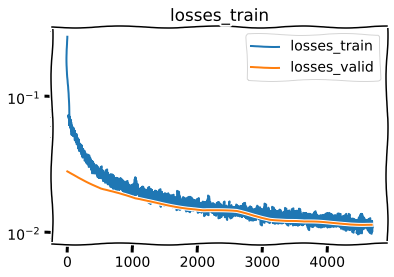

In [7]:
plot_loss(losses_train, losses_valid)

### Result plotting

In [8]:
def plot_reconstructions(encoder, decoder, xs=None):
    autoencoder.eval()
    if xs is None:
        xs, ys = next(iter(data_loader_valid))
    zs = encoder(xs)
    xs_hat = decoder(zs)

    xs = xs.detach().numpy()
    zs = zs.detach().numpy()
    xs_hat = xs_hat.detach().numpy()

    for i in range(8):
        plt.subplot(3, 8, i + 1)
        plt.title("original")
        plt.imshow(xs[i].squeeze(), cmap='gray')
        plt.xticks([])
        plt.yticks([])

        plt.subplot(3, 8, 8 + i + 1)
        plt.title("output")
        plt.imshow(xs_hat[i].squeeze(), cmap='gray')
        plt.xticks([])
        plt.yticks([])

        plt.subplot(3, 8, 16 + i + 1)
        x_diff = xs[i] - xs_hat[i]
        plt.title(f"Error: {np.linalg.norm(x_diff):.1f}")
        plt.imshow(x_diff.squeeze())
        plt.xticks([])
        plt.yticks([])

    plt.gcf().set_size_inches(15, 8)
    plt.tight_layout()
    plt.show()

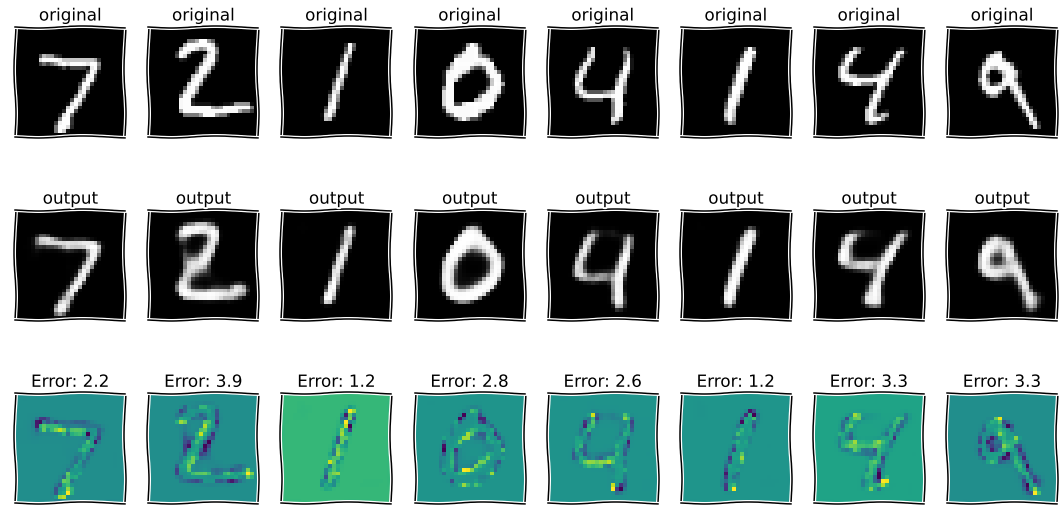

In [9]:
plot_reconstructions(encoder, decoder)

### Exploring latent space

#### Plotting the latent representation for the first image

In [10]:
def plot_the_first_latent_sample(encoder):
    xs, ys = next(iter(data_loader_valid))
    zs = encoder(xs).detach().numpy()

    for c in range(16):
        plt.subplot(2, 8, c+1)
        plt.imshow(zs[0][c])
        plt.colorbar()

    plt.gcf().set_size_inches(20, 4)
    plt.tight_layout()
    plt.show()

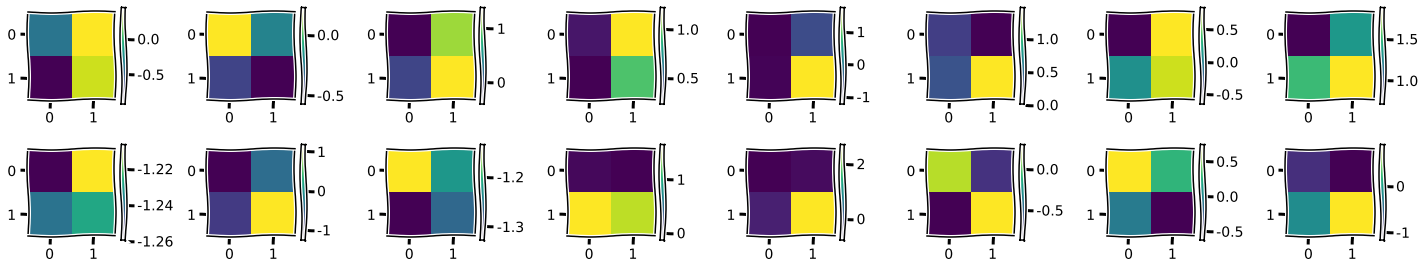

In [11]:
plot_the_first_latent_sample(encoder)

#### Try to mimic a latent random sample

In [12]:
def plot_for_gaussian_random_samples(decoder):
    xs, ys = next(iter(data_loader_valid))
    zs = encoder(xs).detach().numpy()

    μ = zs.mean()
    σ = zs.std()

    zs_mimic = torch.randn([8, 16, 2, 2]) * σ + μ

    xs_mimic = decoder(zs_mimic).detach().numpy()

    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.title("mimic")
        plt.imshow(xs_mimic[i].squeeze(), cmap='gray')
        plt.xticks([])
        plt.yticks([])

    plt.gcf().set_size_inches(15, 3)
    plt.tight_layout()
    plt.show()

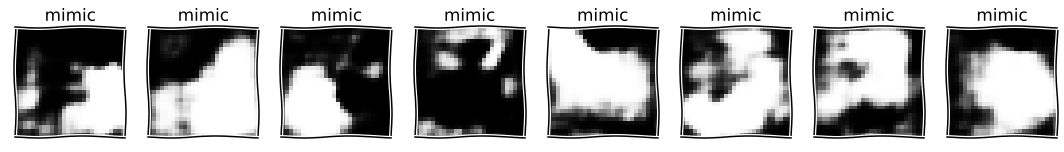

In [13]:
plot_for_gaussian_random_samples(decoder)

As we see, generating random Gaussian sampels with the same mean an variance fails missably.

Maybe we can interpolate?

In [14]:
def plot_interpolations(decoder):
    xs, ys = next(iter(data_loader_valid))
    zs = encoder(xs).detach().numpy()

    for sample_index in range(4):
        z_a = torch.tensor(zs[sample_index:sample_index+1])
        z_b = torch.tensor(zs[sample_index+1:sample_index+2])

        zs_mimic = []

        for α in np.linspace(0, 1, 8):
            z_mimic = (1 - α) * z_a + α * z_b
            zs_mimic.append(z_mimic)

        zs_mimic = torch.cat(zs_mimic)

        xs_mimic = decoder(zs_mimic).detach().numpy()

        for i in range(8):
            plt.subplot(1, 8, i+1)
            plt.imshow(xs_mimic[i].squeeze(), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.gcf().set_size_inches(15, 3)
        plt.tight_layout()
        plt.show()

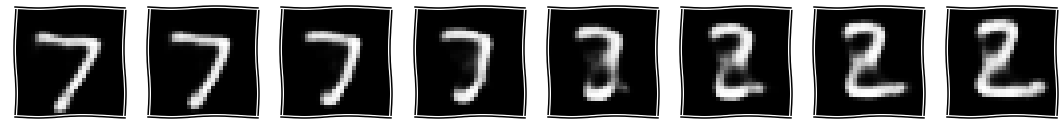

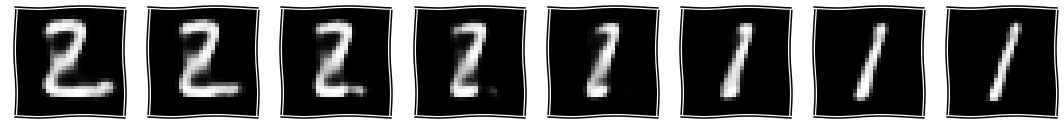

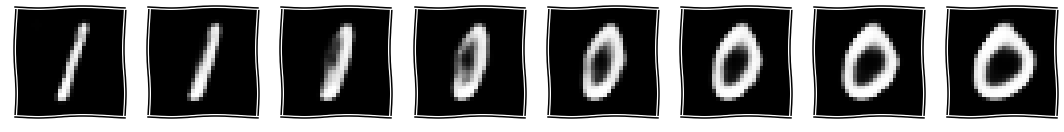

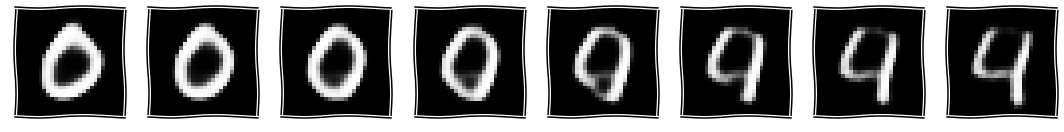

In [15]:
plot_interpolations(decoder)

This is less chaotic and works a bit better, but it does not really look nice and like we have create new samples.

## Sparse autoencoder example

In [16]:
encoder, decoder, autoencoder = get_models()

criterion = nn.MSELoss()
penalty = nn.L1Loss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

n_epochs = 10
λ = 1.

losses_train = []
losses_valid = []

In [17]:
for _ in range(n_epochs):
    autoencoder.train()
    for xs, ys in tqdm(data_loader_train):
        zs = encoder(xs)
        xs_hat = decoder(zs)

        loss = criterion(xs_hat, xs) + λ * penalty(zs, torch.zeros_like(zs))
        losses_train.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    autoencoder.eval()
    losses_valid_tmp = []
    for xs, ys in data_loader_valid:
        xs_hat = autoencoder(xs)
        loss = criterion(xs_hat, xs) + penalty(zs, torch.zeros_like(zs))
        losses_valid_tmp.append(loss.item())
    losses_valid.append(np.mean(losses_valid_tmp))

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

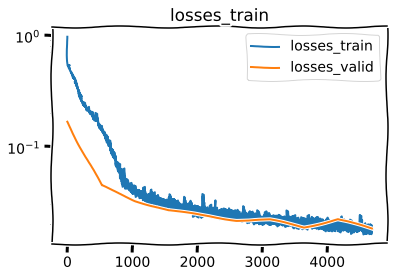

In [18]:
plot_loss(losses_train, losses_valid)

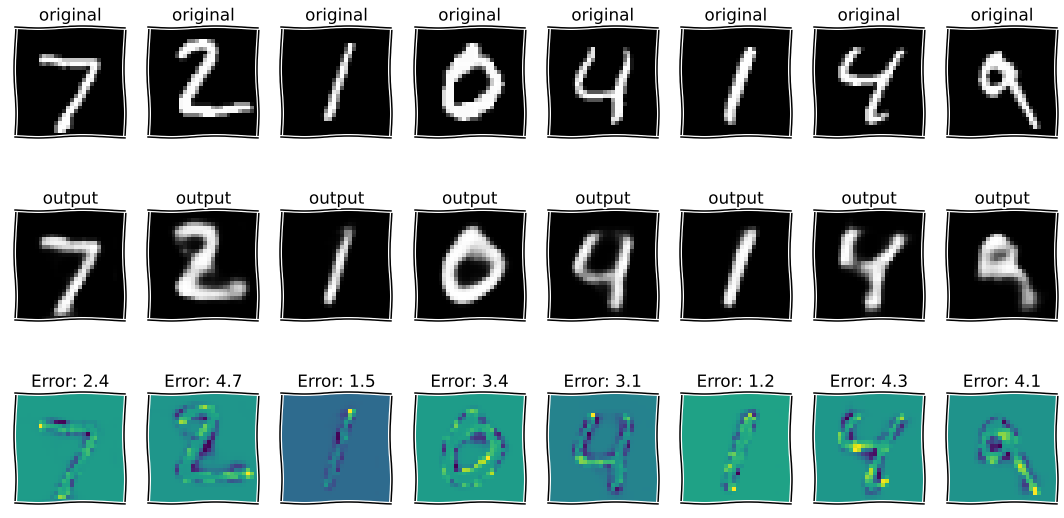

In [19]:
plot_reconstructions(encoder, decoder)

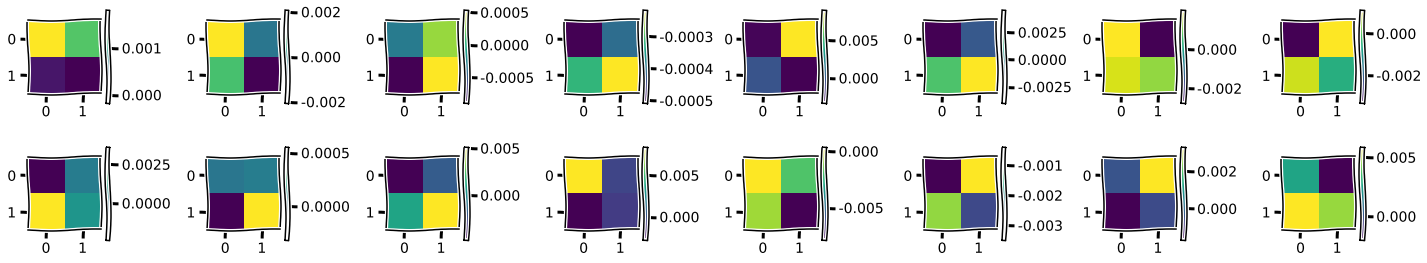

In [20]:
plot_the_first_latent_sample(encoder)

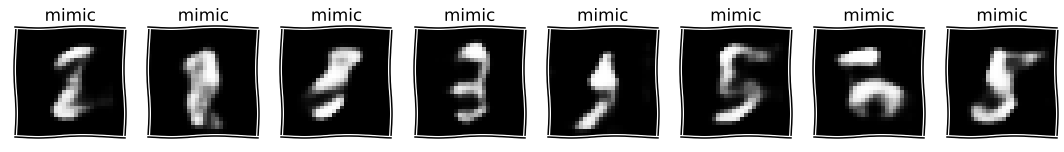

In [21]:
plot_for_gaussian_random_samples(decoder)

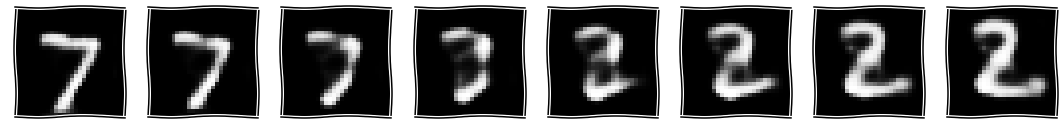

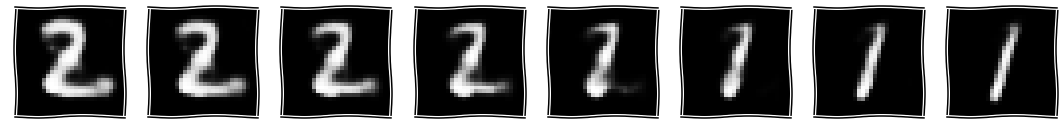

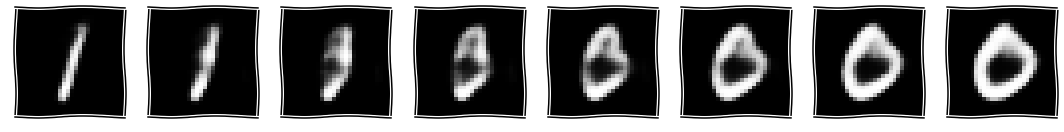

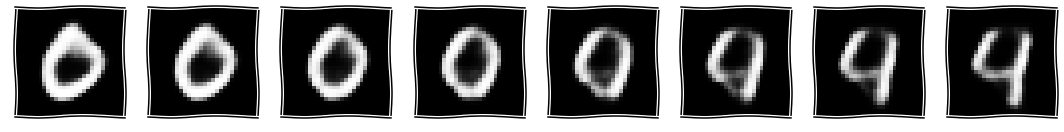

In [22]:
plot_interpolations(decoder)

## Denoising autoencoder example

In [23]:
encoder, decoder, autoencoder = get_models()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

n_epochs = 10
σ = 1.

losses_train = []
losses_valid = []

In [24]:
for _ in range(n_epochs):
    autoencoder.train()
    for xs, ys in tqdm(data_loader_train):
        xsδ = xs + σ * torch.randn_like(xs)
        xs_hat = autoencoder(xsδ)

        loss = criterion(xs_hat, xs)
        losses_train.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    autoencoder.eval()
    losses_valid_tmp = []
    for xs, ys in data_loader_valid:
        xsδ = xs + σ * torch.randn_like(xs)
        xs_hat = autoencoder(xsδ)
        loss = criterion(xs_hat, xs)
        losses_valid_tmp.append(loss.item())
    losses_valid.append(np.mean(losses_valid_tmp))

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

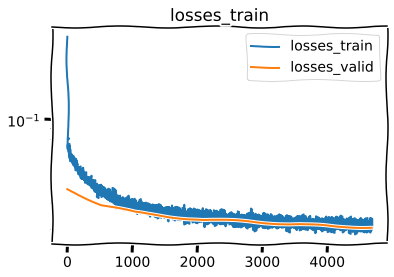

In [25]:
plot_loss(losses_train, losses_valid)

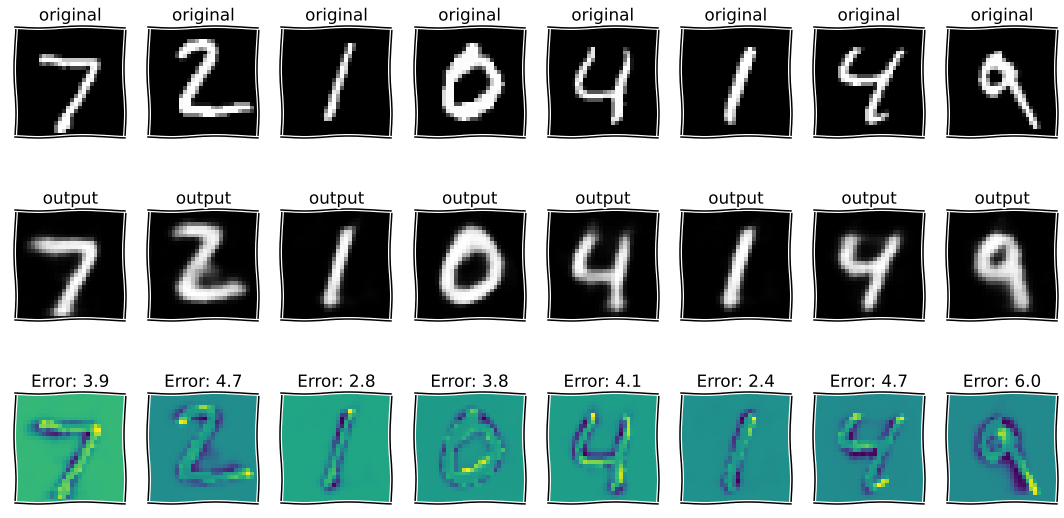

In [26]:
plot_reconstructions(encoder, decoder)

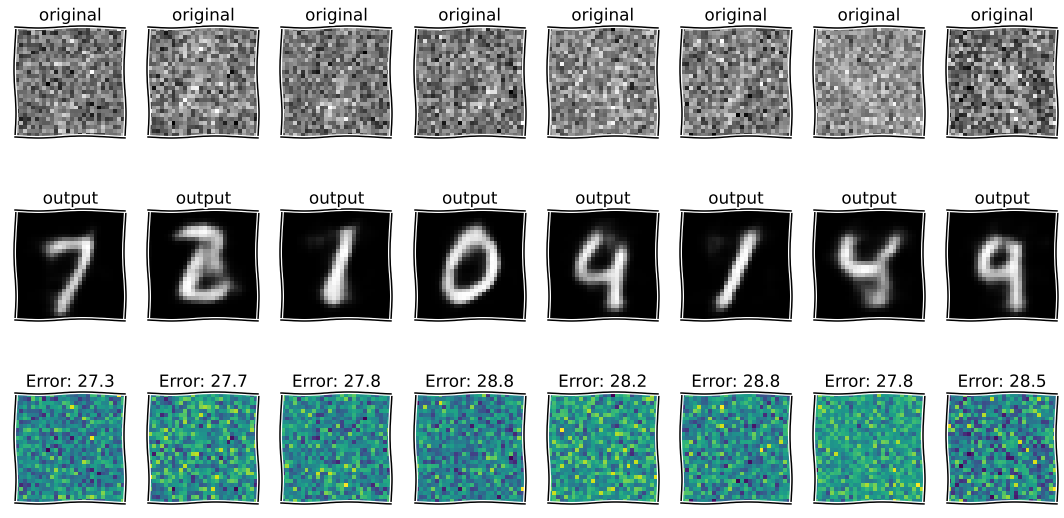

In [27]:
xs, ys = next(iter(data_loader_valid))
xsδ = xs + σ * torch.randn_like(xs)
plot_reconstructions(encoder, decoder, xs=xsδ)

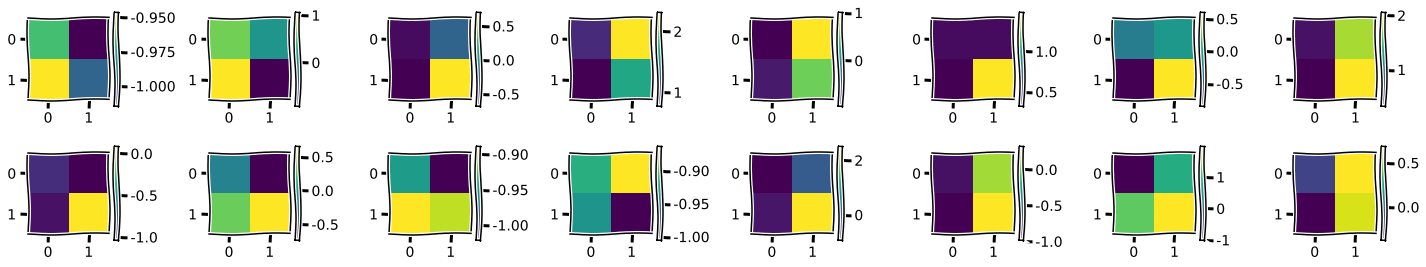

In [28]:
plot_the_first_latent_sample(encoder)

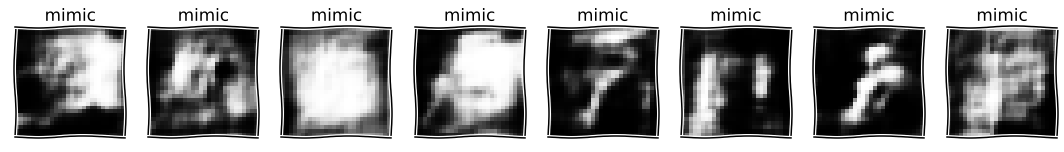

In [29]:
plot_for_gaussian_random_samples(decoder)

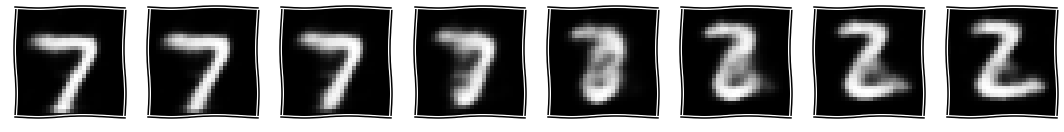

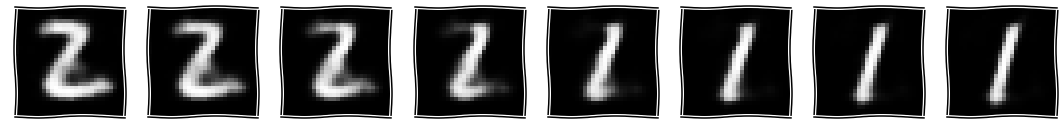

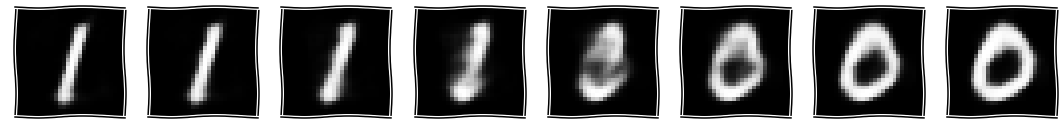

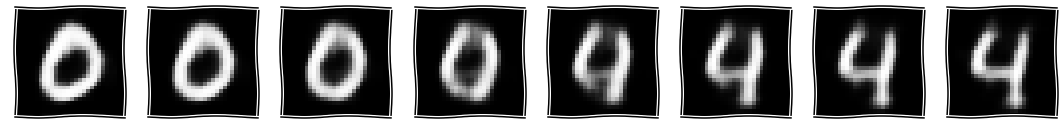

In [30]:
plot_interpolations(decoder)

## Exercises
* Implement a denoising and sparse autoencoder.
* Implement a "sparse" autoencoder in which you replace the $\ell_1$ penalty with a general $\ell_p$ penalty. Plot the results like above for the $\ell_2$ case.
* Implement an autoencoder with a linear encoder and linear decoder (without biases). Compare the reconstruction quality the reconstruction quality of a PCA with the same latent dimensionality.